In [1]:
import pandas as pd

# Read data
df = pd.read_excel("MyFoodData.xlsx")

# Drops unrelevant columns
df = df.filter(items = ["Name", "Calories", "Protein (g)"])
df.head()

,Name,Calories,Protein (g)
0,Pillsbury Golden Layer Buttermilk Biscuits Art...,307.0,5.88
1,Pillsbury Cinnamon Rolls With Icing Refrigerat...,330.0,4.34
2,Kraft Foods Shake N Bake Original Recipe Coati...,377.0,6.10
3,George Weston Bakeries Thomas English Muffins,232.0,8.00
4,Waffles Buttermilk Frozen Ready-To-Heat,273.0,6.58


In [2]:
def calculateFitness(chromosome: list, maxWeight: int, negative: bool):
    totalValue = 0
    totalWeight = 0

    for i in range(len(chromosome)):
        if chromosome[i] == 1:
            value = df.iloc[i]['Protein (g)']
            totalValue += value
            
            weight = df.iloc[i]['Calories']
            totalWeight += weight
    
    proteinWeight = 10
    # Penalty if the weight exceeds maxWeight
    if totalWeight > maxWeight:
        penalty = (totalWeight - maxWeight) ** 1.5
        fitness = proteinWeight * totalValue - penalty
    # No penalty
    else:
        fitness = proteinWeight * totalValue

    finalFitness = fitness if negative else max(1, fitness)
    return finalFitness

In [20]:
import random 

def initializePopulation(populationSize: int, chromosomeSize: int, seed: int = None):
    population = []

    # Set seed
    if seed is not None:
        random.seed(seed)

    # Randomly generate populationSize amount of chromosomes with chromosomeSize size
    for i in range(populationSize):
        member = [random.randint(0, 1) for i in range(chromosomeSize)]
        population.append(member)
    
    random.seed(None)
    
    return population

In [44]:
def sortPopulation(population: list[list], maxWeight: int, negative: bool):
    return sorted(population, key=lambda individual: calculateFitness(individual, maxWeight, negative), reverse=True)

population = initializePopulation(5, 5, 42)
for i in population:
    print(f"{i}, Fitness {calculateFitness(i, 2000, False)}")
print()
population = sortPopulation(population, 2000, False)
for i in population:
    print(f"{i}, Fitness {calculateFitness(i, 2000, False)}")

print(random.randint(1, 10))

[0, 0, 1, 0, 0], Fitness 61.0
[0, 0, 0, 1, 0], Fitness 80.0
[0, 0, 0, 0, 0], Fitness 1
[0, 1, 0, 1, 1], Fitness 189.20000000000002
[0, 0, 1, 1, 1], Fitness 206.8

[0, 0, 1, 1, 1], Fitness 206.8
[0, 1, 0, 1, 1], Fitness 189.20000000000002
[0, 0, 0, 1, 0], Fitness 80.0
[0, 0, 1, 0, 0], Fitness 61.0
[0, 0, 0, 0, 0], Fitness 1
6


In [5]:
def rouletteWheelSelection(population: list[list], maxWeight: int):
    total_fitness = 0
    fitnesses = []

    # Add all fitnesses
    for i in population:
        # Negative fitness is not allowed
        fitness = calculateFitness(i, maxWeight, False)
        fitnesses.append(fitness)
        total_fitness += fitness

    # An individual in the population have fitness / (sum of all fitnesses) chance to be selected in the Roulette Wheel Selection
    prob_sum = 0
    # Random float as roulette
    roulette = random.uniform(0, total_fitness)
    for i in range(len(population)):
        # If the prob_sum + fitness of the individual exceedes the roulette value, the roulette is in that probability area, so the individual is selected
        # Example:
        # If we have 5 individuals with fitness values 5, 10, 15, 6, 3 and roulette as 21, the individual with fitness value 15 should be selected.
        # In the first iteration of the loop prob_sum would be 5, in the second iteration 15 and in the third iteration it would be 30, exceeding the roulette value
        # Third individual from the population would be selected according to this algorithm
        prob_sum += fitnesses[i]
        if prob_sum > roulette:
            return population[i]

        

In [6]:
def tournamentSelection(population: list[list], tournamentSize: int, maxWeight: int):
    # tournamentSize amount of individuals are selected for the tournament
    randomIndividuals = random.sample(range(0, len(population)), tournamentSize)
    bestFitness = -1
    bestIndividual = []
    #print(randomIndividuals)
    
    for i in randomIndividuals:
        # Individual with best fitness wins the tournament
        # This individual is selected
        fitness = calculateFitness(population[i], maxWeight, False)
        #print(f"Individual {i}, fitness {fitness}")
        if fitness > bestFitness:
            bestFitness = fitness
            bestIndividual = i
    return population[bestIndividual]


In [7]:
population = initializePopulation(10, 5)

bestIndividual = tournamentSelection(population, 4, 2500)
print(bestIndividual)

[0, 0, 0, 1, 1]


In [8]:
population = initializePopulation(10, 5)
for i in range(len((population))):
    print(population[i], calculateFitness(population[i], 2500, False))

print()
selected = rouletteWheelSelection(population, 2500)
print(selected)

[1, 1, 0, 0, 0] 102.19999999999999
[1, 0, 1, 1, 0] 199.8
[1, 0, 0, 0, 1] 124.60000000000001
[1, 1, 0, 1, 1] 247.99999999999997
[0, 1, 0, 1, 0] 123.4
[1, 1, 0, 0, 0] 102.19999999999999
[1, 0, 1, 1, 1] 265.6
[0, 1, 1, 0, 1] 170.2
[1, 0, 1, 1, 1] 265.6
[0, 1, 1, 0, 0] 104.39999999999999

[1, 1, 0, 0, 0]


In [9]:
import random

def singlePointCrossover(firstParent: list, secondParent: list):

   # Selects a random crossover point
   crossOverPoint = random.randint(1, len(firstParent) - 1)

   # Selects the crossover parts from parents (From random point to end of the chromosome)
   crossOverPart1 = firstParent[crossOverPoint: len(firstParent)]
   crossOverPart2 = secondParent[crossOverPoint: len(secondParent)]

   firstOffspring = firstParent
   secondOffspring = secondParent

   # Swaps the crossover parts between parents
   firstOffspring[crossOverPoint: len(firstParent)] = crossOverPart2
   secondOffspring[crossOverPoint: len(secondParent)] = crossOverPart1

   return [firstOffspring, secondOffspring]

In [10]:
firstParent = [0, 0 , 1, 1, 0, 1]
secondParent = [1, 1, 0, 0, 0, 1]

offsprings = singlePointCrossover(firstParent, secondParent)
print(offsprings)

[[0, 0, 1, 1, 0, 1], [1, 1, 0, 0, 0, 1]]


In [11]:
def multiplePointCrossover(firstParent: list, secondParent: list):
    # Selects two random crossover points
    firstCrossOverPoint = random.randint(1, len(firstParent) - 1)
    secondCrossOverPoint = random.randint(1, len(secondParent) - 1)

    # Change the crossover point if the points are same
    while (firstCrossOverPoint == secondCrossOverPoint):
        secondCrossOverPoint = random.randint(1, len(firstParent) - 1)
    
    # If the first crossover point is at the right of the second crossover point swap the points
    if (firstCrossOverPoint > secondCrossOverPoint):
        firstCrossOverPoint, secondCrossOverPoint = secondCrossOverPoint, firstCrossOverPoint
    
    # Select the crossover parts from point1 to point2
    crossOverPart1 = firstParent[firstCrossOverPoint: secondCrossOverPoint + 1]
    crossOverPart2 = secondParent[firstCrossOverPoint: secondCrossOverPoint + 1]

    firstOffspring = firstParent
    secondOffspring = secondParent

    # Swap the crossover parts between parents
    firstOffspring[firstCrossOverPoint: secondCrossOverPoint + 1] = crossOverPart2
    secondOffspring[firstCrossOverPoint: secondCrossOverPoint + 1] = crossOverPart1

    return [firstOffspring, secondOffspring]

    


In [12]:
firstParent = [0, 0 , 1, 1, 0, 1]
secondParent = [1, 1, 0, 0, 0, 1]

offsprings = multiplePointCrossover(firstParent, secondParent)
print(offsprings)

[[0, 0, 0, 0, 0, 1], [1, 1, 1, 1, 0, 1]]


In [13]:
def uniformCrossover(firstParent: list, secondParent: list, maxWeight: int):
    firstFitness = calculateFitness(firstParent, maxWeight, True)
    secondFitness = calculateFitness(secondParent, maxWeight, True)

    minFitness = min(firstFitness, secondFitness)
    if minFitness <= 0:
        shift = abs(minFitness) + 1
        firstFitness += shift
        secondFitness += shift

    # Probability in the uniform crossover is fp_1 / (fp_1 + fp_2), where fp_1 is the fitness of the first parent and fp_2 is the fitness of the second parent
    probability = firstFitness / (firstFitness + secondFitness)

    firstOffspring = []
    secondOffspring = []
    i = 0
    length = len(firstParent)
    while (len(firstOffspring) != length):
        randomProb = random.random()
        # First chromosome have the chance fp_1 / (fp_1 + fp_2) to the get the gene from first parent.
        # If the probability is higher than the random value, first offspring gets the gene from first parent
        # This repeats for all of the genes (length of the chromosome)
        if (randomProb < probability):
            firstOffspring.append(firstParent[i])
            secondOffspring.append(secondParent[i])
        else:
            firstOffspring.append(secondParent[i])
            secondOffspring.append(firstParent[i])
        i += 1

    return [firstOffspring, secondOffspring]



In [14]:
firstParent = [0, 0 , 1, 1, 0, 1]
secondParent = [1, 1, 0, 0, 0, 1]

offsprings = uniformCrossover(firstParent, secondParent, 1000)
print(offsprings)

[[1, 0, 1, 0, 0, 1], [0, 1, 0, 1, 0, 1]]


In [15]:
def mutation(chromosome: list, rate: int):
    mutationsRate = 1 / rate
    for i in range(len(chromosome)):
        # random.random() generates a float between 0 and 1
        # If this number is less than or equal to mutation rate there is a bit flip in that gene (mutation occurs)
        if random.random() <= mutationsRate:
            chromosome[i] = 1 - chromosome[i]
    return chromosome

In [16]:
chromosome = [0, 0, 1, 1, 1, 0, 1]
print(mutation(chromosome, 10))

[1, 0, 1, 1, 1, 0, 1]


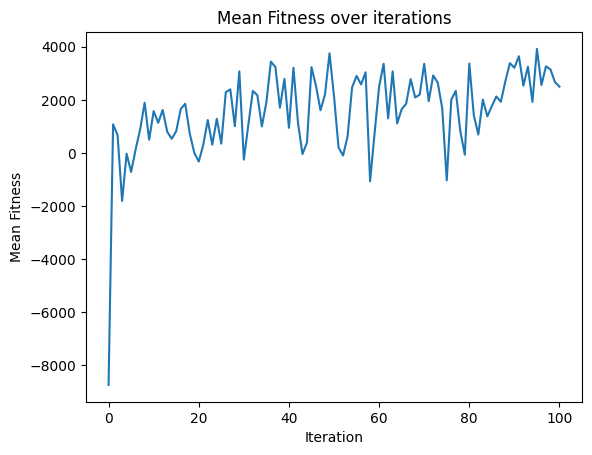

In [45]:
import numpy as np
import matplotlib.pyplot as plt

populationSize = 100
chromosomeSize = 100
seed = 42
population = initializePopulation(populationSize, chromosomeSize, seed)

def geneticAlgorithm(population: list[list], maxWeight: int, generations: int, elitSize: int):
    meanFitness = []
    fitnessList = [calculateFitness(i, maxWeight, True) for i in population]
    mean = np.mean(fitnessList)
    meanFitness.append(mean)

    for i in range(generations):
        sortedPopulation = sortPopulation(population, maxWeight, True)
        new_population = sortedPopulation[:elitSize]
        while len(new_population) != len(population):
            
            firstIndividual = tournamentSelection(population, 2, maxWeight)
            secondIndividual = tournamentSelection(population, 2, maxWeight)
        
            #firstIndividual = rouletteWheelSelection(population, maxWeight)
            #secondIndividual = rouletteWheelSelection(population, maxWeight)
            
            #offsprings = singlePointCrossover(firstIndividual, secondIndividual)
            offsprings = uniformCrossover(firstIndividual, secondIndividual, maxWeight)
            #offsprings = multiplePointCrossover(firstIndividual, secondIndividual)
            offsprings[0] = mutation(offsprings[0], len(offsprings[0]))
            offsprings[1] = mutation(offsprings[1], len(offsprings[1]))

            new_population.extend(offsprings)

        population = new_population
        #print(f"Generation {i}")
        #print(population)

        fitnessList = [calculateFitness(i, maxWeight, True) for i in population]
        mean = np.mean(fitnessList)
        meanFitness.append(mean)

    x = np.arange(0, generations + 1)
    plt.plot(x, meanFitness)
    plt.title("Mean Fitness over iterations")
    plt.xlabel("Iteration")
    plt.ylabel("Mean Fitness")
    return population

maxWeight = 20000
generations = 100
elitismSize = 2
new = geneticAlgorithm(population, maxWeight, generations, elitismSize)


In [46]:
sortedNew = sortPopulation(new, maxWeight, True)

for i in sortedNew:
    fitness = calculateFitness(i, maxWeight, True)
    totalWeight = 0
    totalProtein = 0
    
    for j in range(len(i)):
        if i[j]:  
            protein = df.iloc[j]['Protein (g)']
            weight = df.iloc[j]['Calories']
            totalProtein += protein
            totalWeight += weight

    print(f"Fitness {fitness}, calorie {totalWeight}, protein {totalProtein}")

"""
print(sortedNew[0])
for i, value in enumerate(sortedNew[0]):
    if value == 1:
        print(f"Name: {df.iloc[i]['Name']}, Protein (g): {df.iloc[i]['Protein (g)']}, Calories: {df.iloc[i]['Calories']}")
"""

Fitness 5372.7, calorie 19974.0, protein 537.27
Fitness 5362.5, calorie 19912.0, protein 536.25
Fitness 5351.1, calorie 19974.0, protein 535.11
Fitness 5344.8, calorie 19872.0, protein 534.48
Fitness 5300.8, calorie 19590.0, protein 530.08
Fitness 5292.7, calorie 19742.0, protein 529.27
Fitness 5264.8, calorie 20016.0, protein 532.88
Fitness 5258.700000000001, calorie 19878.0, protein 525.8700000000001
Fitness 5251.599999999999, calorie 19153.0, protein 525.16
Fitness 5244.9, calorie 19806.0, protein 524.49
Fitness 5230.799999999999, calorie 19192.0, protein 523.0799999999999
Fitness 5230.1, calorie 19460.0, protein 523.01
Fitness 5229.700000000001, calorie 19495.0, protein 522.97
Fitness 5222.7, calorie 19518.0, protein 522.27
Fitness 5218.6, calorie 19550.0, protein 521.86
Fitness 5216.799999999999, calorie 19788.0, protein 521.68
Fitness 5216.599999999999, calorie 18917.0, protein 521.66
Fitness 5193.400000000001, calorie 19592.0, protein 519.34
Fitness 5190.900000000001, calorie 19

'\nprint(sortedNew[0])\nfor i, value in enumerate(sortedNew[0]):\n    if value == 1:\n        print(f"Name: {df.iloc[i][\'Name\']}, Protein (g): {df.iloc[i][\'Protein (g)\']}, Calories: {df.iloc[i][\'Calories\']}")\n'